In [16]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
#     context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule

/home/jlaw/Sync/nrel/arpa-e/rlmolecule_branch/examples/stable_radical_optimization


In [3]:
# connect to the db
dbname = "bde"
port = "5432"
host = "yuma.hpc.nrel.gov"
user = "rlops"
# read the password from a file
passwd_file = '/projects/rlmolecule/rlops_pass'
with open(passwd_file, 'r') as f:
    passwd = f.read().strip()

drivername = "postgresql+psycopg2"
engine_str = f'{drivername}://{user}:{passwd}@{host}:{port}/{dbname}'
engine = sqlalchemy.create_engine(engine_str, execution_options={"isolation_level": "AUTOCOMMIT"})

# Initial Results
Eagle is really backed up, so these results are from multiple runs on the debug queue (which has a 1 hr time limit)

In [4]:
# run_id = 'stable_radical_optimization'
run_id = '20210408_mol_diversity-2'

In [30]:
# load the games played
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore
Session.configure(bind=engine)
session = Session()
df = pd.read_sql(session.query(GameStore).filter_by(run_id=run_id).statement, session.bind)

df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
df = df.sort_values('time_hours')
df_games = df
df_games.reset_index(drop=True, inplace=True)
df_games.head()

,id,run_id,time,raw_reward,scaled_reward,search_statistics,time_hours
0,9f992f56-edd0-4a4a-8529-aef6d402efa7,20210408_mol_diversity-2,2021-04-08 16:18:46.102357,35.286669,1.0,[[a323322f10ab649b203db742294f7b2d47a7101e987d...,0.000000
1,f8a912ee-b587-4ceb-91d3-fef24b75f3d2,20210408_mol_diversity-2,2021-04-08 16:18:46.272271,78.616650,0.0,[[a323322f10ab649b203db742294f7b2d47a7101e987d...,0.000047
2,392dfb5a-6655-4b33-bc46-8020cac5fcfa,20210408_mol_diversity-2,2021-04-08 16:18:46.677905,70.801911,0.0,[[a323322f10ab649b203db742294f7b2d47a7101e987d...,0.000160
3,23304ede-ad4d-42a8-8d22-be7bed9dbf03,20210408_mol_diversity-2,2021-04-08 16:18:46.863937,62.953034,1.0,[[a323322f10ab649b203db742294f7b2d47a7101e987d...,0.000212
4,9dd618eb-57bd-4367-b213-aca095b34423,20210408_mol_diversity-2,2021-04-08 16:18:46.924792,69.349816,0.0,[[a323322f10ab649b203db742294f7b2d47a7101e987d...,0.000228


In [59]:
df_games.search_statistics[0][1][0]

'43a78e85b4160a57ed76bcf5425bb10604e9560043e698f2b4e2140fadcca2ae'

In [11]:
log.head()

,epoch,loss,policy_wrapper_1_loss,policy_wrapper_loss,time
0,0,0.758693,0.161665,0.597027,2021-04-08 16:21:06.216231
1,1,0.691711,0.155681,0.536030,2021-04-08 16:22:13.611817
2,2,0.689219,0.156723,0.532496,2021-04-08 16:23:23.917059
3,3,0.730584,0.170839,0.559745,2021-04-08 16:24:35.893391
4,4,0.738978,0.170744,0.568234,2021-04-08 16:25:50.902612


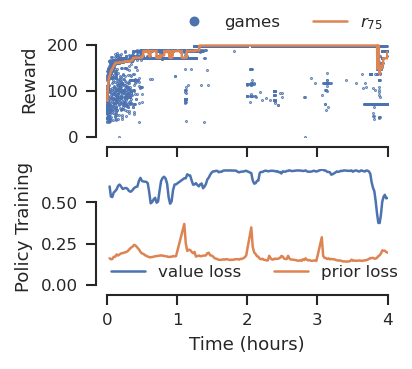

In [33]:
if log is not None:
    log['time'] = pd.to_datetime(log.time)
    log['time_hours'] = (log.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)

df_games = df_games.sort_values('time_hours')
df = df_games

fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(2.75, 2.5), dpi=150)

axs[0].plot(df.time_hours, df.raw_reward, '.', ms=.75, label='games')
axs[0].plot(df.time_hours, df.raw_reward.rolling(250, min_periods=50).quantile(.75), label='$r_{75}$')

if log is not None:
    axs[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
    axs[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')

axs[0].legend(loc='upper right', ncol=2, borderpad=0, borderaxespad=0.3, bbox_to_anchor=(1., 1.1), markerscale=10)
axs[1].legend(ncol=2, borderpad=0, borderaxespad=0.3)

axs[0].set_ylim([0, 250])

axs[0].set_ylabel('Reward')
axs[1].set_ylabel('Policy Training')
axs[1].set_xlabel('Time (hours)')

axs[1].set_ylim([0, .7])
axs[1].set_xlim([-.01, 4])

plt.tight_layout()
sns.despine(offset=5, trim=True)

# Measure the spin, buried volume, and draw the molecule

TODO: Need to join the tables, and unpickle the state to get the smile strings from the state

In [26]:
# look at some of the top rewards
df = pd.read_sql(session.query(RewardStore).filter_by(run_id=run_id).statement, session.bind)
# df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
df = df.sort_values('reward', ascending=False)
df_rew = df
# df_rewards.reset_index(drop=True, inplace=True)
df_rew.head(3)
# how do I get the state back from the hash/digest?

,digest,hash,run_id,time,reward,data
97336,a84e72cd2c91d8d9db328af5e3b7ddd2287d48660bc7ee...,6675330499563234736,20210408_mol_diversity-2,2021-04-08 16:55:25.553472,194.345381,"{'max_spin': '0.22334908', 'spin_buried_vol': ..."
53892,5841ca4fd3404c68b09bbc74e1386d62932f8277a5dd9b...,-8546084274829997730,20210408_mol_diversity-2,2021-04-08 16:28:26.124941,193.096789,"{'max_spin': '0.18126908', 'spin_buried_vol': ..."
97508,bc718b4ea0798c87e4531fbaa8ba915b82f933e8ae70d2...,3307902544955723709,20210408_mol_diversity-2,2021-04-08 16:55:50.503506,189.717817,"{'max_spin': '0.2694718', 'spin_buried_vol': '..."


In [28]:
df_rew.iloc[0]

digest    a84e72cd2c91d8d9db328af5e3b7ddd2287d48660bc7ee...
hash                                    6675330499563234736
run_id                             20210408_mol_diversity-2
time                             2021-04-08 16:55:25.553472
reward                                           194.345381
data      {'max_spin': '0.22334908', 'spin_buried_vol': ...
Name: 97336, dtype: object

In [29]:
df_rew.iloc[0]['data']

{'max_spin': '0.22334908',
 'spin_buried_vol': '56.579987',
 'ionization_energy': '0.8489394187927246',
 'electron_affinity': '-0.372755765914917',
 'bde': '76.95124',
 'bde_diff': '-4.2158127',
 'forced_terminal': True,
 'smiles': 'O=c1c([CH]O)c(SO)c(=O)c(=O)c1=O'}

In [19]:
# Code for raster image drawing
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdDepictor
from IPython.display import SVG

In [50]:
# row = pass_gng.sample(1, random_state=5).iloc[0]
# mol = Chem.MolFromSmiles(row.smiles)

d = rdMolDraw2D.MolDraw2DSVG(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(mol, [float(i) for i in pred_spins(mol)], draw2d=d)
d.FinishDrawing()
SVG(d.GetDrawingText())

NameError: name 'pred_spins' is not defined

# Leftover code from augmenting_reward branch:

In [ ]:
with psycopg2.connect(**config.dbparams) as conn:
    experiment_ids = pd.read_sql_query("select distinct experiment_id from {}_game".format(config.sql_basename), conn)
    
experiment_ids

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(13, 3), sharex=True, sharey=True)

optimal = []
for ax, atom in zip(axs, ['C', 'N', 'O', 'S']):
    
    ax.plot(rew_df[rew_df.atom_type == atom]['max_spin'],
            rew_df[rew_df.atom_type == atom]['buried_vol'], '.', ms=1, alpha=.1, label='All radicals')
    
    ax.plot(stable_max_spin[stable_max_spin['atom-sym'] == atom]['fractional_spin'],
            stable_max_spin[stable_max_spin['atom-sym'] == atom]['bur-vol'],
            '.', label='Experimentally stable')
    
    ax.plot(pass_gng[pass_gng.atom_type == atom]['max_spin'],
            pass_gng[pass_gng.atom_type == atom]['buried_vol'], '.', ms=1, label='Pass GNG')
    
    ax.set_title(atom)
    
axs[1].set_xlabel('Max Fractional Spin')
axs[0].set_ylabel('Buried volume\nat max spin')

axs[-1].legend(loc='upper left', fontsize=12, markerscale=2)
sns.despine()    

In [ ]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(rew_df['ea'], rew_df['ie'], '.', ms=1, alpha=.1)
ax.plot(pass_gng['ea'], pass_gng['ie'], '.', ms=1, color='g')

ax.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 2])

ax.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax.set_ylabel(r'$E_{1/2}^o$, IE (V)')

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

sns.kdeplot(rew_df.bde, label='All radicals')
sns.kdeplot(pass_gng.bde, label='Pass GNG', color='g')
plt.xlabel('BDE')
plt.ylabel('Frequency')

In [ ]:
df = rew_df[~rew_df.index.isin(pass_gng.index)].sort_values('real_reward', ascending=False)

In [ ]:
pass_gng.sample(10)

In [ ]:
rew_df[rew_df.real_reward > 200]

In [ ]:
rew_df.real_reward.max()

In [ ]:
plt.hist(rew_df.ie - rew_df.ea, bins=20)

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

plt.hist(rew_df.real_reward, label='All radicals', range=(0, 225))
plt.hist(pass_gng.real_reward, label='Pass GNG', color='g', range=(0, 225))
plt.xlabel('Reward')
plt.ylabel('Frequency')

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [ ]:
from reward import predict, stability_model
from alphazero.node import Node

def pred_spins(mol):
    spins, _ = predict(stability_model, 
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(mol).policy_inputs.items()})
    
    return spins.numpy().flatten()

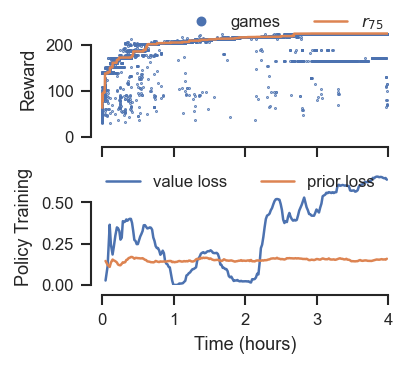

In [24]:
# Load the game buffer
with psycopg2.connect(**config.dbparams) as conn:
    df = pd.read_sql_query("select * from {}_game where experiment_id = %s".format(
        config.sql_basename), conn, params=(config.experiment_id,))
    
# Load the policy training history
try:
    log = pd.read_csv(os.path.join(config.checkpoint_filepath, 'log.csv'))
    log['time'] = pd.to_datetime(log.time)
except Exception:
    log = None

df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)

if log is not None:
    log['time_hours'] = (log.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)

df = df.sort_values('time_hours')

fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(2.75, 2.5), dpi=150)

axs[0].plot(df.time_hours, df.real_reward, '.', ms=.75, label='games')
axs[0].plot(df.time_hours, df.real_reward.rolling(250, min_periods=50).quantile(.75), label='$r_{75}$')

if log is not None:
    axs[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
    axs[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')

axs[0].legend(loc='upper right', ncol=2, borderpad=0, borderaxespad=0.3, bbox_to_anchor=(1., 1.1), markerscale=10)
axs[1].legend(ncol=2, borderpad=0, borderaxespad=0.3)

axs[0].set_ylim([0, 250])

axs[0].set_ylabel('Reward')
axs[1].set_ylabel('Policy Training')
axs[1].set_xlabel('Time (hours)')

axs[1].set_ylim([0, .7])
axs[1].set_xlim([-.01, 4])

plt.tight_layout()
sns.despine(offset=5, trim=True)
# plt.savefig('20210204_policy_loss.svg')

In [ ]:
with psycopg2.connect(**config.dbparams) as conn:
    experiment_ids = pd.read_sql_query("select distinct experiment_id from {}_game".format(config.sql_basename), conn)
    
experiment_ids

In [26]:
# Load the reward buffer to plot the optimal molecules
with psycopg2.connect(**config.dbparams) as conn:
    rew_df = pd.read_sql_query("select * from {}_reward".format(config.sql_basename), conn)

rew_df.shape

(192514, 10)

In [28]:
rew_df.sort_values('real_reward', ascending=False).head(20)

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index,ie,ea,bde
176797,CCC(C)(C)c1c([O])oc(C)c1C(C)=O,2021-02-17 09:45:59.768796,228.93843,C,71.134260,0.343698,5,0.887471,-0.318515,66.861620
125498,CC(=O)c1c(C)oc([O])c1C(C)(C)C,2021-02-17 08:09:52.966174,226.83424,C,68.008606,0.323353,9,0.875751,-0.312925,66.374540
125094,CCC(=O)c1c(C)oc([O])c1C(C)(C)C,2021-02-17 08:09:20.995981,226.61505,C,67.752914,0.322622,10,0.888569,-0.305805,66.333340
136281,CN(C)C(=O)c1cc([O])oc1C(C)(C)C,2021-02-17 08:20:08.744508,225.49966,C,65.384890,0.297704,10,1.035426,-0.222373,66.808180
165312,CC(C)(C)c1oc([O])cc1CC1CCC1,2021-02-17 09:13:38.791297,224.90038,C,64.735200,0.296694,4,0.785250,-0.380811,64.063410
175509,Cc1c([O])oc(C(C)(C)C)c1C(=O)O,2021-02-17 09:41:10.768260,224.88399,C,64.216760,0.286655,5,1.049485,-0.198916,64.054910
136082,CC(C)(C)c1oc([O])cc1C1CCCC1,2021-02-17 08:19:55.934197,224.66174,C,64.541245,0.297513,4,0.836493,-0.368242,63.879440
134082,C=C(CC)c1cc(C)cc2oc([O])cc12,2021-02-17 08:18:14.043986,224.45474,C,60.641690,0.223551,4,0.867900,-0.291949,67.947070
134135,COC(=O)c1c(C(C)(C)C)oc([O])c1C,2021-02-17 08:18:15.852003,224.38110,C,64.325590,0.298889,5,1.025686,-0.223408,64.045340
124170,CC(C)(C)c1ccc([O])n1CCC#N,2021-02-17 08:08:22.791707,224.02309,C,65.790290,0.300760,4,0.719211,-0.381316,66.194930


In [ ]:
stable_df = pd.read_csv('/home/pstjohn/Research/20200608_redox_calculations/stable_radicals/spin-charges-bur-vol-stable-radicals-all-atoms-with-smi.csv')

stable_df_noH = stable_df[~stable_df['atom-sym-idx'].str.startswith('H')]
stable_df['fractional_spin'] = stable_df_noH.groupby('File')['spin-density'].transform(lambda x: x.abs() / x.abs().sum())

stable_idx_max_spin = stable_df.groupby('File').fractional_spin.idxmax()
stable_max_spin = stable_df.loc[stable_idx_max_spin]

In [44]:
from rdkit import Chem

In [ ]:
stable_df['smiles'] = stable_df.Smiles.apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))

In [ ]:
rew_df[rew_df.smiles.isin(stable_df.smiles)]

In [ ]:
pass_gng = rew_df[(rew_df.bde < 80) & (rew_df.bde > 60) &
                  (rew_df.ie < 1.2) & (rew_df.ea > -.5) &
                  ((rew_df.ie - rew_df.ea) > 1) &
                  ((rew_df.buried_vol + 50 * (1 - rew_df.max_spin)) > 100.)]

In [ ]:
pass_gng.shape

In [ ]:
pass_gng.to_csv('20210109_gng_radicals.csv.gz', compression='gzip')

In [ ]:
from reward import redox_model, predict

In [ ]:
from alphazero.node import Node

In [ ]:
import tensorflow as tf

In [ ]:
def pred_redox(smiles):
    return predict(redox_model,
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(rdkit.Chem.MolFromSmiles(smiles)).policy_inputs.items()}).numpy().flatten()

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
redox = pass_gng.smiles.progress_apply(pred_redox)

In [ ]:
plt.plot(np.vstack(redox.values)[:, 0], pass_gng.ie, '.')

In [ ]:
(pass_gng.ie - np.vstack(redox.values)[:, 0]).abs().mean()

In [ ]:
Node(rdkit.Chem.MolFromSmiles('CC(=S)C1=C(C)[CH]CCC1(C)C')).policy_inputs

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(13, 3), sharex=True, sharey=True)

optimal = []
for ax, atom in zip(axs, ['C', 'N', 'O', 'S']):
    
    ax.plot(rew_df[rew_df.atom_type == atom]['max_spin'],
            rew_df[rew_df.atom_type == atom]['buried_vol'], '.', ms=1, alpha=.1, label='All radicals')
    
    ax.plot(stable_max_spin[stable_max_spin['atom-sym'] == atom]['fractional_spin'],
            stable_max_spin[stable_max_spin['atom-sym'] == atom]['bur-vol'],
            '.', label='Experimentally stable')
    
    ax.plot(pass_gng[pass_gng.atom_type == atom]['max_spin'],
            pass_gng[pass_gng.atom_type == atom]['buried_vol'], '.', ms=1, label='Pass GNG')
    
    ax.set_title(atom)
    
axs[1].set_xlabel('Max Fractional Spin')
axs[0].set_ylabel('Buried volume\nat max spin')

axs[-1].legend(loc='upper left', fontsize=12, markerscale=2)
sns.despine()    

In [ ]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(rew_df['ea'], rew_df['ie'], '.', ms=1, alpha=.1)
ax.plot(pass_gng['ea'], pass_gng['ie'], '.', ms=1, color='g')

ax.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 2])

ax.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax.set_ylabel(r'$E_{1/2}^o$, IE (V)')

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

sns.kdeplot(rew_df.bde, label='All radicals')
sns.kdeplot(pass_gng.bde, label='Pass GNG', color='g')
plt.xlabel('BDE')
plt.ylabel('Frequency')

In [ ]:
df = rew_df[~rew_df.index.isin(pass_gng.index)].sort_values('real_reward', ascending=False)

In [ ]:
pass_gng.sample(10)

In [ ]:
rew_df[rew_df.real_reward > 200]

In [ ]:
rew_df.real_reward.max()

In [ ]:
plt.hist(rew_df.ie - rew_df.ea, bins=20)

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

plt.hist(rew_df.real_reward, label='All radicals', range=(0, 225))
plt.hist(pass_gng.real_reward, label='Pass GNG', color='g', range=(0, 225))
plt.xlabel('Reward')
plt.ylabel('Frequency')

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [ ]:
from reward import predict, stability_model
from alphazero.node import Node

def pred_spins(mol):
    spins, _ = predict(stability_model, 
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(mol).policy_inputs.items()})
    
    return spins.numpy().flatten()

In [49]:
# Code for raster image drawing
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdDepictor
from IPython.display import SVG

In [ ]:
row = pass_gng.sample(1, random_state=5).iloc[0]
mol = Chem.MolFromSmiles(row.smiles)

d = rdMolDraw2D.MolDraw2DSVG(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(mol, [float(i) for i in pred_spins(mol)], draw2d=d)
d.FinishDrawing()
SVG(d.GetDrawingText())